# Исследование сервиса GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. \
Сервисом можно пользоваться:
 - без подписки:\
   абонентская плата отсутствует;\
   стоимость одной минуты поездки — 8 рублей;\
   стоимость старта (начала поездки) — 50 рублей;
 - с подпиской Ultra:\
   абонентская плата — 199 рублей в месяц;\
   стоимость одной минуты поездки — 6 рублей;\
   стоимость старта — бесплатно.

### Цель исследования:

  1) Описать и визуализировать общую информацию (количество поездок, расстояние одной поездки, возраст пользователей и т.д.);\
  2) Изучить информацию о пользователях без подписки и с ней;\
  3) Подсчитать выручку с каждого пользователя;\
  4) Проверить необходимые гипотезы.
  
   #### Ход исследования:
  
   Данные получим из трёх файлов: /datasets/users_go.csv, /datasets/rides_go.csv, /datasets/subscriptions_go.csv. О качестве данных ничего не известно, поэтому необходимо будет тщательно изучить их.
   
   На этапе предобработки данных найдём все пропущенные значения, обработаем их, удалим явные выбросы, избавимся от дубликатов. После этого совместим все данные в одну таблицу, создадим ещё 2 датафрейма отдельно для пользователей с подпиской и без и начнём достигать цели исследования.
   
   Таким образом, работа состоит из следующих этапов:
   
   - обзор полученных данных;
   - предобработка данных;
   - добавление необходимой информации в таблицу;
   - проведение анализа по конкретным столбцам;
   - совмещение датафреймов и создание новых;
   - подсчёт выручки;
   - проверка гипотез;
   - подобрать распределения для акций компании;
   - написание общего вывода.

### Загрузка данных

Импортируем все необходимые библиотеки:

In [291]:
#Импорт необходимых библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st

Имеем три исходных таблицы, прочитаем их:

In [292]:
#Прочитаем таблицы и сохраним их:
users_data = pd.read_csv('/datasets/users_go.csv')
rides_data = pd.read_csv('/datasets/rides_go.csv')
subscriptions_data = pd.read_csv('/datasets/subscriptions_go.csv')

Изучим каждую по очереди. Для этого выведем по 5 строк и общую информацию:

In [293]:
#Изучим таблицу с пользователями:
print(users_data.head())
users_data.info()

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [294]:
#Изучим таблицу с поездками:
print(rides_data.head())
rides_data.info()

   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [295]:
#Изучим таблицу с тарифами:
print(subscriptions_data.head())
subscriptions_data.info()

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


#### Вывод: 
Из приятного: сразу видим, что пропусков нет. На полторы тысячи пользователей приходится около 18000 поездок, вполне успешное предприятие. Тип данных в столбце "date" нуждается в правке.

### Предобработка данных

Первым делом проверим таблицу с пользователями и поездками на явные дубликаты:

In [296]:
#Проверка на явные дубликаты:
print(users_data.duplicated().sum())
print(rides_data.duplicated().sum())

31
0


Удалим обнаруженные дубликаты из таблицы с пользователями:

In [297]:
#Удаление явных дубликатов:
users_data = users_data.drop_duplicates()
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Убедимся, что пользователи теперь действительно не повторяются:

In [298]:
#Повторная проверка на явные дубликаты:
users_data['user_id'].duplicated().sum()

0

Проверим названия городов на предмет неявных дубликатов:

In [299]:
#Проверка на неявные дубликаты:
users_data['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Маловато городов, хотя всего-то 1500 человек.

Округлим значения расстояния и продолжительности поездок из второй таблицы до целых чисел в большую сторону:

In [300]:
#Округление необходимых значений:
rides_data['duration'] = np.ceil(rides_data['duration'])
rides_data['distance'] = np.ceil(rides_data['distance'])
print(rides_data.head())

   user_id  distance  duration        date
0        1    4410.0      26.0  2021-01-01
1        1    2618.0      16.0  2021-01-18
2        1     755.0       7.0  2021-04-20
3        1    2695.0      19.0  2021-08-11
4        1    4029.0      27.0  2021-08-28


Изменим тип данных в этих столбцах на целочисленный:

In [301]:
#Изменим тип данных двух столбцов:
rides_data['duration'] = rides_data['duration'].astype('int')
rides_data['distance'] = rides_data['distance'].astype('int')
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   18068 non-null  int64 
 1   distance  18068 non-null  int64 
 2   duration  18068 non-null  int64 
 3   date      18068 non-null  object
dtypes: int64(3), object(1)
memory usage: 564.8+ KB


Проверим столбцы "distance" и "duration" на предмет выбросов:

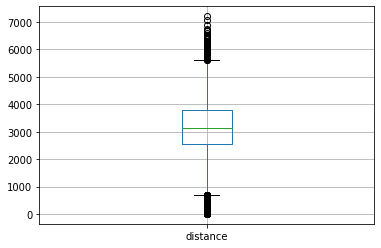

count    18068.000000
mean      3071.159841
std       1116.831548
min          1.000000
25%       2543.750000
50%       3134.000000
75%       3777.000000
max       7212.000000
Name: distance, dtype: float64

In [302]:
#Диаграмма размаха для столбца "distance":
rides_data.boxplot(column='distance')
plt.show()

rides_data['distance'].describe()

7 км достаточно большое расстояние, однако, учитывая города из выборки, вполне реальные данные. Взглянем на поездки менее 1 км:

In [303]:
#Поездки менее 1000 метров:
print(rides_data.query('distance < 1000').sort_values('distance'))

       user_id  distance  duration        date
11555     1069         1        11  2021-01-31
9541       925         3         4  2021-10-19
13690     1223         5         5  2021-05-22
8658       861         7         7  2021-07-21
7841       796         8        11  2021-11-26
...        ...       ...       ...         ...
15873     1381       996        11  2021-09-05
4036       435       998        11  2021-04-22
6451       694       998        12  2021-02-24
12470     1137       999        13  2021-01-15
13533     1213       999        11  2021-01-29

[1371 rows x 4 columns]


Обнаружили крайне малые значения расстояния. При этом время поездки достаточно большое, например, в первом случае. Конечно, человек мог застрять в сугробе и долго вытаскивать самокат из него, либо же просто забыть нажать кнопку завершения поездки, однако для нашего исследования это явный выброс. Посмотрим, сколько и какие строчки попадутся, если поставить ограничение в 300 метров:

In [304]:
#Поездки менее 300 метров:
print(rides_data.query('distance < 300').sort_values('distance'))

       user_id  distance  duration        date
11555     1069         1        11  2021-01-31
9541       925         3         4  2021-10-19
13690     1223         5         5  2021-05-22
8658       861         7         7  2021-07-21
7841       796         8        11  2021-11-26
...        ...       ...       ...         ...
16909     1452       298        11  2021-03-01
8235       829       299         7  2021-05-30
15435     1350       299        13  2021-11-22
12877     1165       299         7  2021-12-04
13224     1192       299         7  2021-04-14

[293 rows x 4 columns]


Около 2% от всей выборки. Аномально большие значения времени встречаются и для 300 метров. Удалим эту часть выборки для более адекватных результатов в будущем:

In [305]:
#Удаление нефизичных данных:
rides_data = rides_data[rides_data['distance'] >= 300]
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   17775 non-null  int64 
 1   distance  17775 non-null  int64 
 2   duration  17775 non-null  int64 
 3   date      17775 non-null  object
dtypes: int64(3), object(1)
memory usage: 694.3+ KB


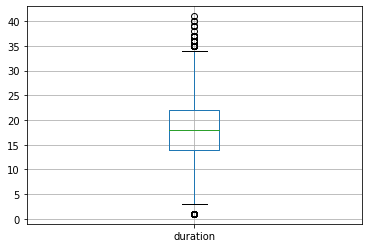

count    17775.000000
mean        18.460985
std          6.000697
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [306]:
#Диаграмма размаха для продолжительности поездок:
rides_data.boxplot(column='duration')
plt.show()

rides_data['duration'].describe()

Время в 35+ минут вполне подходит для расстояний в 5+ км. Выведем конкретные строки таблицы, чтобы убедиться в этом предположении:

In [307]:
#Проверка гипотезы:
print(rides_data.query('duration > 35'))

      user_id  distance  duration        date
42          4      4650        36  2021-08-14
143        15      4188        39  2021-01-13
499        55      4152        37  2021-06-30
524        58      4764        36  2021-02-17
854        91      4445        36  2021-11-05
1111      119      4061        36  2021-05-15
1455      158      3968        36  2021-05-09
1621      174      3795        36  2021-12-23
1694      183      4474        37  2021-01-02
1894      205      4219        37  2021-08-26
1998      216      4832        39  2021-05-11
2163      231      4457        36  2021-06-14
2232      239      4263        36  2021-02-17
2264      242      4562        36  2021-07-26
2279      243      3916        37  2021-12-30
2530      268      4699        36  2021-06-28
2623      278      4755        40  2021-12-02
2841      304      4787        36  2021-02-26
3729      401      4003        38  2021-09-21
3941      424      4139        36  2021-11-14
4215      454      5138        41 

Вполне похоже на правду, тут корректировать нечего.

In [308]:
#Проверка гипотезы:
print(rides_data.query('distance > 6000'))

       user_id  distance  duration        date
6860       724      6226         1  2021-12-16
7043       737      6387        26  2021-07-31
7052       738      6060        22  2021-05-02
7185       747      6011        19  2021-03-10
7612       780      6113         1  2021-11-23
7617       781      6106        20  2021-01-11
7632       781      6087        27  2021-12-21
7635       782      6396        29  2021-02-22
7830       795      6263         1  2021-09-09
7913       803      6428        17  2021-01-05
8527       850      6437        35  2021-12-27
8650       860      6004        27  2021-09-07
9027       888      6013        22  2021-11-11
9288       907      6252        20  2021-07-26
9451       919      6039        31  2021-05-04
9622       931      6003         1  2021-11-10
9756       941      6252        27  2021-11-06
9794       944      6144        21  2021-06-29
10144      967      6022        21  2021-11-03
10341      981      6672        28  2021-12-06
10432      98

А вот здесь уже возникают вопросы. Да, кто-то действительно может проехать 7 км за 23 минут, повезло со светофорами, однако 6+ км за 30 секунд уже фантастика. Выведем все строки с этим странным значением:

In [309]:
#Просмотр сомнительных данных:
print(rides_data.query('duration == 0.5'))

Empty DataFrame
Columns: [user_id, distance, duration, date]
Index: []


Аж 95 строчек с проблемными 30 секундами. Никакой связи между ними нет (кроме того, что с таким столкнулись исключительно пользователи второй половины списка). Возможно, это результат какой-то акции, например, "первая поездка почти даром". Проверим это предположение: выведем все поездки пользователя с id 701:

In [310]:
#Проверка гипотезы:
print(rides_data.query('user_id == 701'))

      user_id  distance  duration        date
6518      701      2677        18  2021-01-23
6519      701      2744        15  2021-02-13
6520      701      2894        12  2021-02-20
6521      701      2803        17  2021-03-12
6522      701      3510        14  2021-04-17
6523      701      2466        15  2021-05-31
6524      701       732         7  2021-06-02
6525      701      3904        19  2021-06-20
6526      701      3442        19  2021-07-04
6527      701      1134         7  2021-07-17
6528      701      3989        21  2021-07-28
6529      701      4408        19  2021-07-28
6530      701      3433        18  2021-08-31
6531      701      4197         1  2021-08-31
6532      701      4520        16  2021-09-09
6533      701      4140        17  2021-09-25
6534      701      4370        14  2021-10-22
6535      701      4026        30  2021-10-27
6536      701      2421        10  2021-12-10
6537      701       353        13  2021-12-15


Предположение не подтвердилось, значит, это мог быть просто какой-то купон. В любом случае за разъяснениями нужно обратиться к составителям таблицы, гадать бессмысленно. 95 строчек составляют меньше 1% от общего списка, однако эти данные способны внести смуту в ходе исследования, поэтому удалим их:

In [311]:
#Удаление нефизичных данных:
rides_data = rides_data[rides_data['duration'] != 0.5]
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   17775 non-null  int64 
 1   distance  17775 non-null  int64 
 2   duration  17775 non-null  int64 
 3   date      17775 non-null  object
dtypes: int64(3), object(1)
memory usage: 694.3+ KB


Построим диаграммы размаха для обновлённых данных:

In [ ]:
#Диаграмма размаха по обновлённым расстояниям:
rides_data.boxplot(column='distance')
plt.ylim = (0, 5000)
plt.show()

rides_data['distance'].describe()

Медиана и среднее незначительно повысились. Это несильно скажется на результатах анализа.

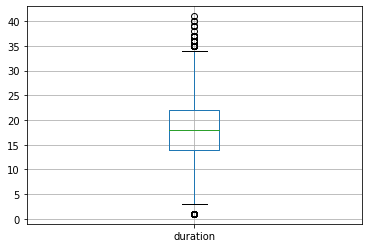

count    17775.000000
mean        18.460985
std          6.000697
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [313]:
#Диаграмма размаха по обновлённой продолжительности поездок:
rides_data.boxplot(column='duration')
plt.show()

rides_data['duration'].describe()

Небольшие изменения медианы и среднего, ничего критичного.

In [314]:
#Выведем, сколько же строк от общего числа было удалено в ходе предобработки. Напомним, изначально их было 18068:
print("{:.1%}".format(rides_data['duration'].count()/18068))

98.4%


Суммарно менее 2%, приемлемо.

Изменим тип данных в столбце "date":

In [315]:
#Меняем тип данных столбца "date":
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y.%m.%d')
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17775 non-null  int64         
 1   distance  17775 non-null  int64         
 2   duration  17775 non-null  int64         
 3   date      17775 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 694.3 KB


Создадим новый столбец с номерами месяцев:

In [316]:
#Новый столбец с номерами месяцев поездки:
rides_data['month'] = rides_data['date'].dt.month
print(rides_data['month'].head())

0    1
1    1
2    4
3    8
4    8
Name: month, dtype: int64


Убедимся в том, что данные присутствуют только за 1 год и месяца склеились удачно:

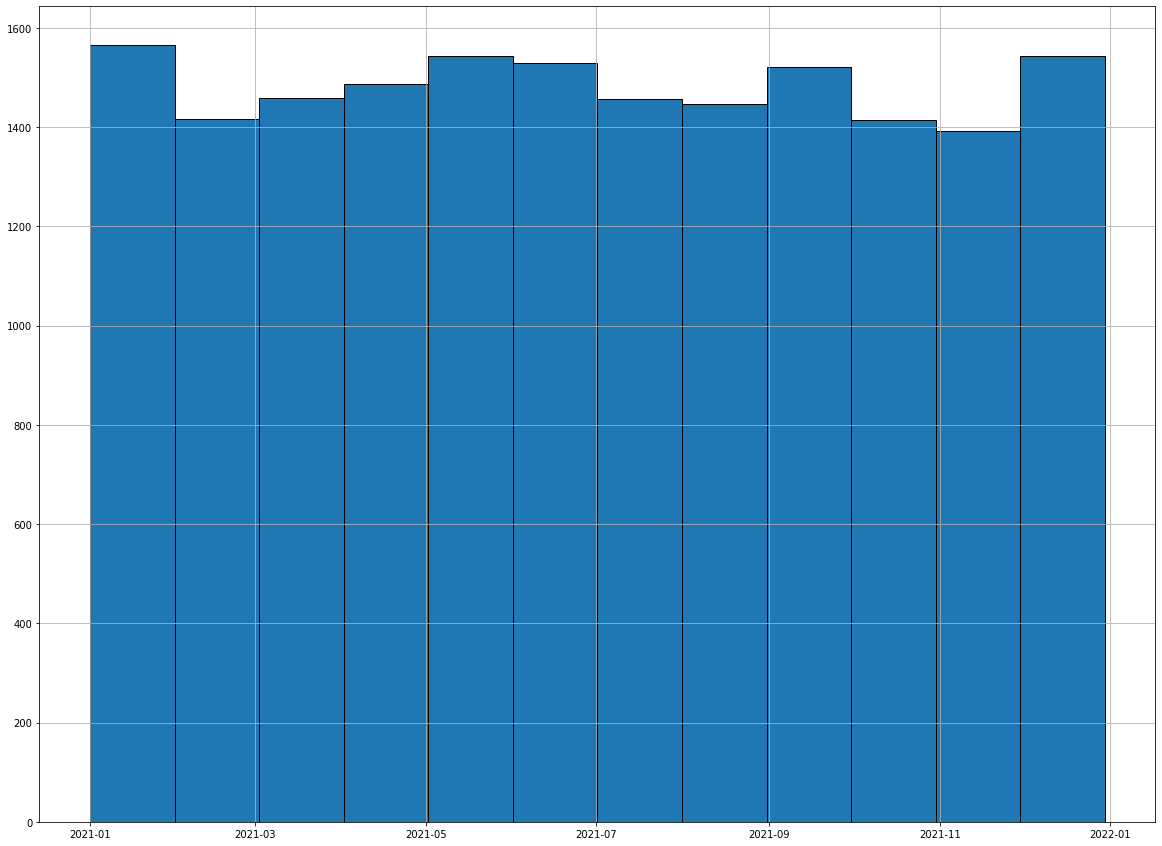

In [317]:
rides_data['date'].hist(bins=12, figsize=(20, 15), edgecolor=(0, 0, 0))
plt.show()

Действительно, данные представлены только за 2021 год.

#### Вывод:
В ходе предобработки данных была проделана следующая работа:
  - были выявлены и удалены явные дубликаты в users_data;
  - была произведена проверка на неявные дубликаты;
  - обнаружены и удалены строки с нефизичными значениями (большие расстояния за 30 секунд, несколько метров за 10+ минут);
  - произведено округление значений в столбцах "distance" и "duration" из rides_data;
  - изменены типы данных в столбцах: "date" датафрейма rides_data, "distance" и "duration" из rides_data;
  - добавлен столбец с номером месяца.
  
Теперь данные готовы к анализу.

### Исследовательский анализ данных

Необходимо описать и визуализировать общую информацию по таблицам. Будем выполнять по пунктам.

#### Частота встречаемости городов

Для анализа потребуется таблица users_data. Нарисуем гистограмму и опишем её:

In [320]:
#Создадим сводную таблицу по городам и количеству клиентов в них:
city_pivot_table = users_data.pivot_table(index='city', values='user_id', aggfunc='count')
city_pivot_table.columns = ['count']
city_pivot_table = city_pivot_table.sort_values('count', ascending=True).head(8)

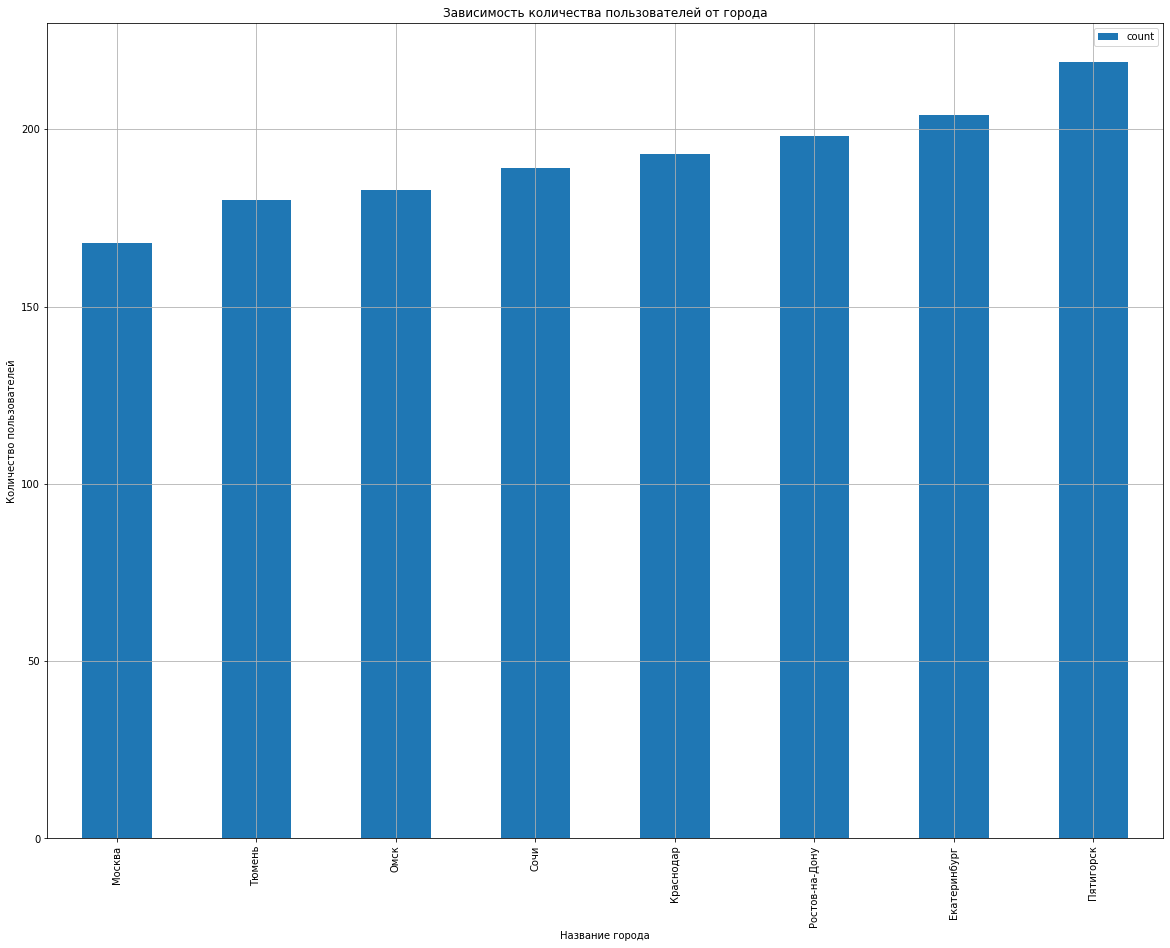

In [321]:
#Гистограмма по городам:
city_pivot_table.plot(y='count', kind = 'bar', grid = True, figsize=(20, 15))
plt.title('Зависимость количества пользователей от города')
plt.ylabel('Количество пользователей')
plt.xlabel('Название города')
plt.show()

Вот так сюрприз, в Москве оказалось меньше всего пользователей сервисом GoFast. Сразу наводит на мысль о нерепрезентативности выборки, однако считаем, что она верна. Значит, в Москве у сервиса больше всего конкурентов, либо же люди чаще пользуются общественным и личным транспортом. Больше всего пользователей из южной части страны (Пятигорск, Краснодар, Ростов-на-Дону). Так же отмечается Екатеринбург, там люди охотно пользуются современными сервисами.

#### Соотношение пользователей с подпиской и без

Потребуется таблица users_data. Построим гистограмму по столбцу "subscription_type":

In [367]:
#Создадим сводную таблицу по типам подписки и количеству клиентов:
sub_pivot_table = users_data.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
sub_pivot_table.columns = ['count']
sub_pivot_table = sub_pivot_table.sort_values('count', ascending=True)
sub_pivot_table['percent'] = sub_pivot_table['count'] / users_data['user_id'].count()
print(sub_pivot_table)

                   count   percent
subscription_type                 
ultra                699  0.455671
free                 835  0.544329


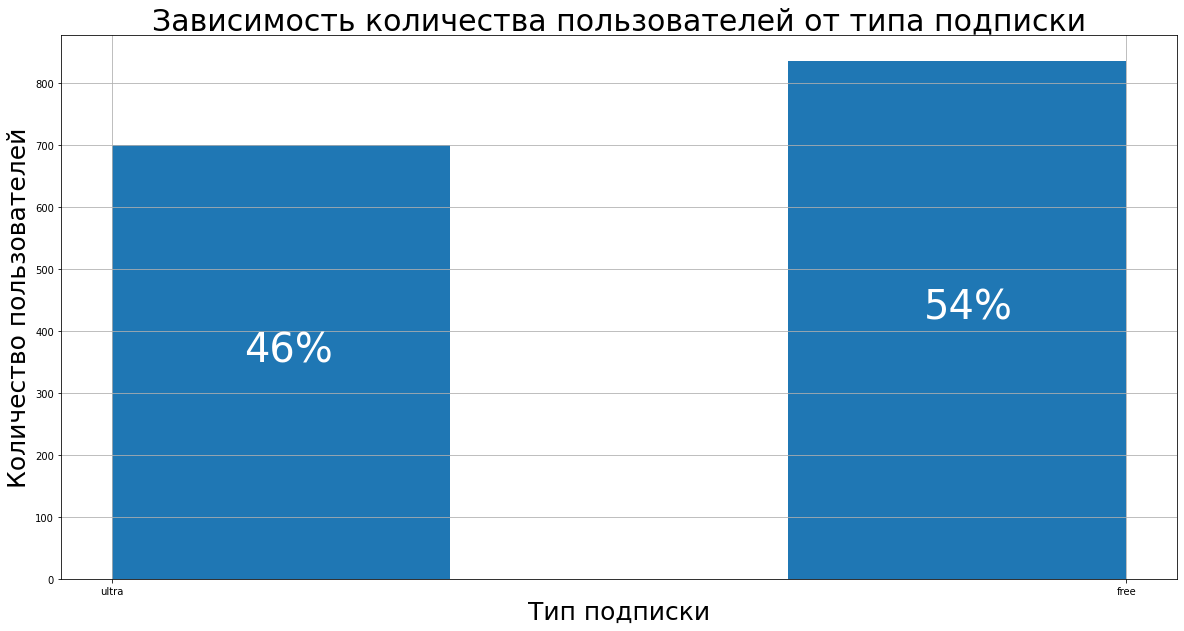

In [390]:
#Гистограмма по типу подписки:
users_data['subscription_type'].hist(bins=3, grid=True, figsize=(20, 10))
plt.title('Зависимость количества пользователей от типа подписки', fontsize=30)
plt.ylabel('Количество пользователей', fontsize=25)
plt.xlabel('Тип подписки', fontsize=25)
plt.text(0.13, 350, "46%", fontsize=40, color='white')
plt.text(0.8, 420, "54%", fontsize=40, color='white')
plt.show()

Пользователей с подпиской "Ultra" оказалось ровно 700 человек, с базовой около 830. Достаточно маленькая разница (8 %), говорит о том, что люди не против приобретения подписки, видимо, часто пользуются сервисом.

#### Возраст пользователей

Потребуется таблица users_data. Построим гистограмму по столбцу "age":

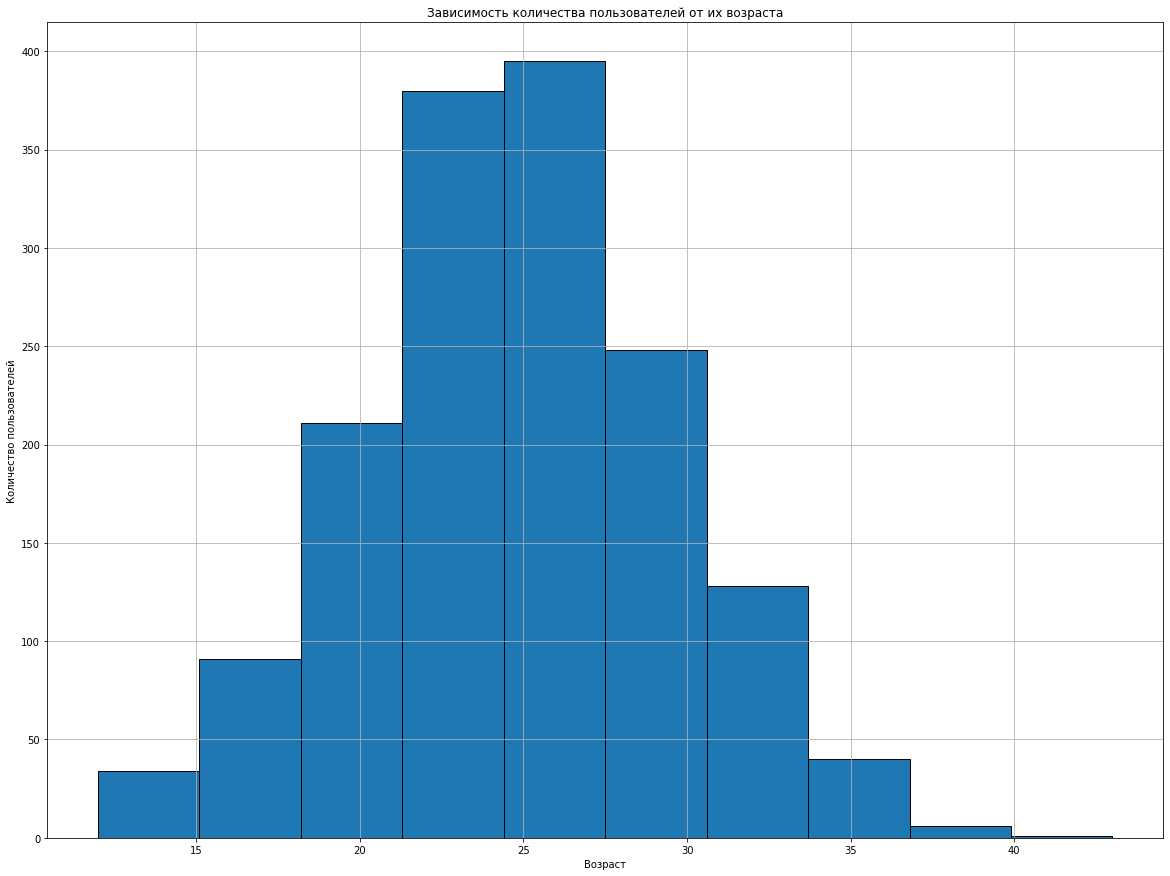

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [322]:
#Гистограмма по возрасту пользователей:
users_data['age'].hist(bins=10, figsize=(20,15), edgecolor=(0, 0, 0))
plt.title('Зависимость количества пользователей от их возраста')
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.show()

users_data['age'].describe()

Визуально можем оценить график как нормальное распределение, у которого среднее и медиана около 25 лет. Видим, что больше всего клиентов в сегменте молодых (21 - 27 лет), однако есть люди и старше, например, за 35. Посмортим, сколько их:

In [196]:
#Оценка данных:
users_data.query('age >= 35')['age'].count()

28

Сервису есть, куда расти.

#### Расстояние, которое пользователь преодолел за одну поездку

Потребуется таблица rides_data. Построим гистограмму по столбцу "distance":

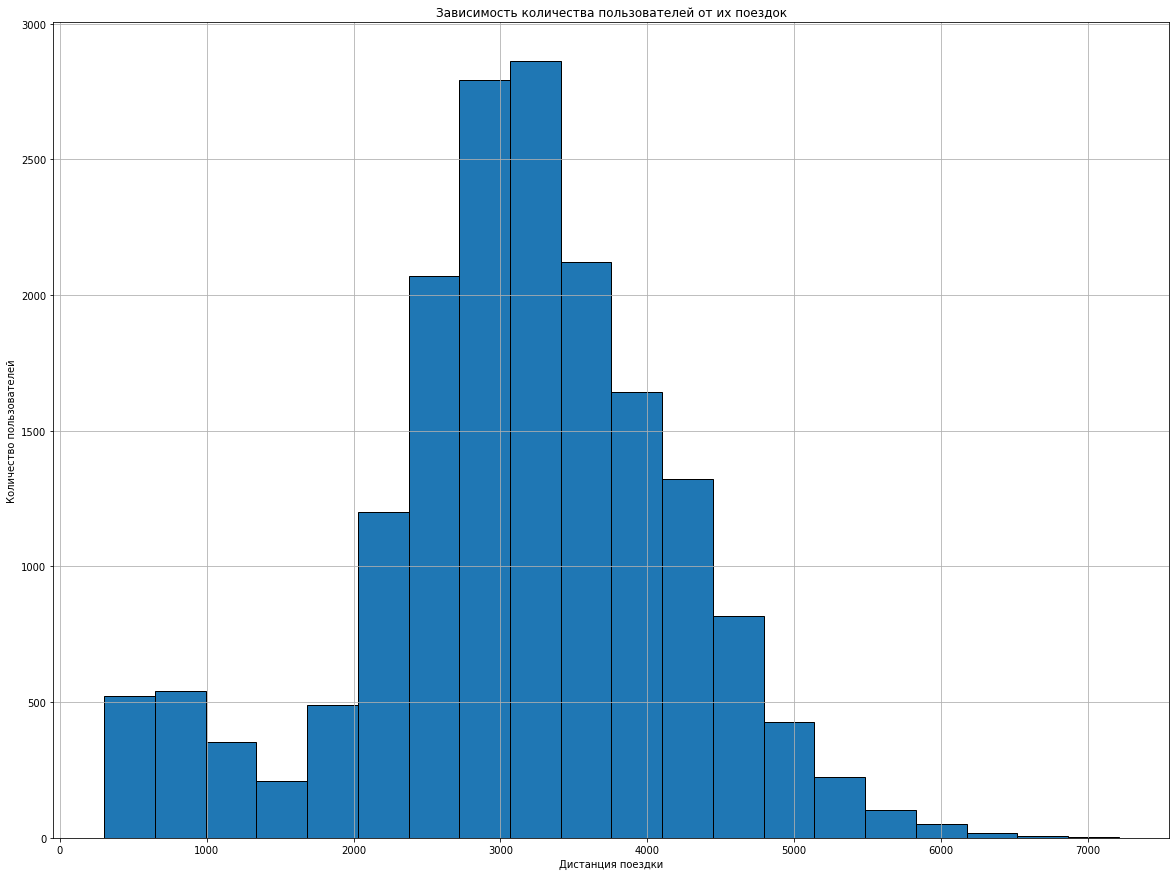

count    17775.000000
mean      3119.018115
std       1061.372113
min        301.000000
25%       2578.000000
50%       3150.000000
75%       3794.500000
max       7212.000000
Name: distance, dtype: float64

In [323]:
#Гистограмма по дистанциям поездок:
rides_data['distance'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0))
plt.title('Зависимость количества пользователей от их поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Дистанция поездки')
plt.show()

rides_data['distance'].describe()

Видим, что чаще всего самокат арендуется для преодоления средних расстояний (пик приходится на 3 км). На расстояния больше 5 км люди предпочитают использовать другие средства перемещения. Также интересно, что самокат достаточно часто используется и для небольших дистанций (менее 1 км).

#### Продолжительность поездок

Потребуется таблица rides_data. Построим гистограмму по столбцу "duration":

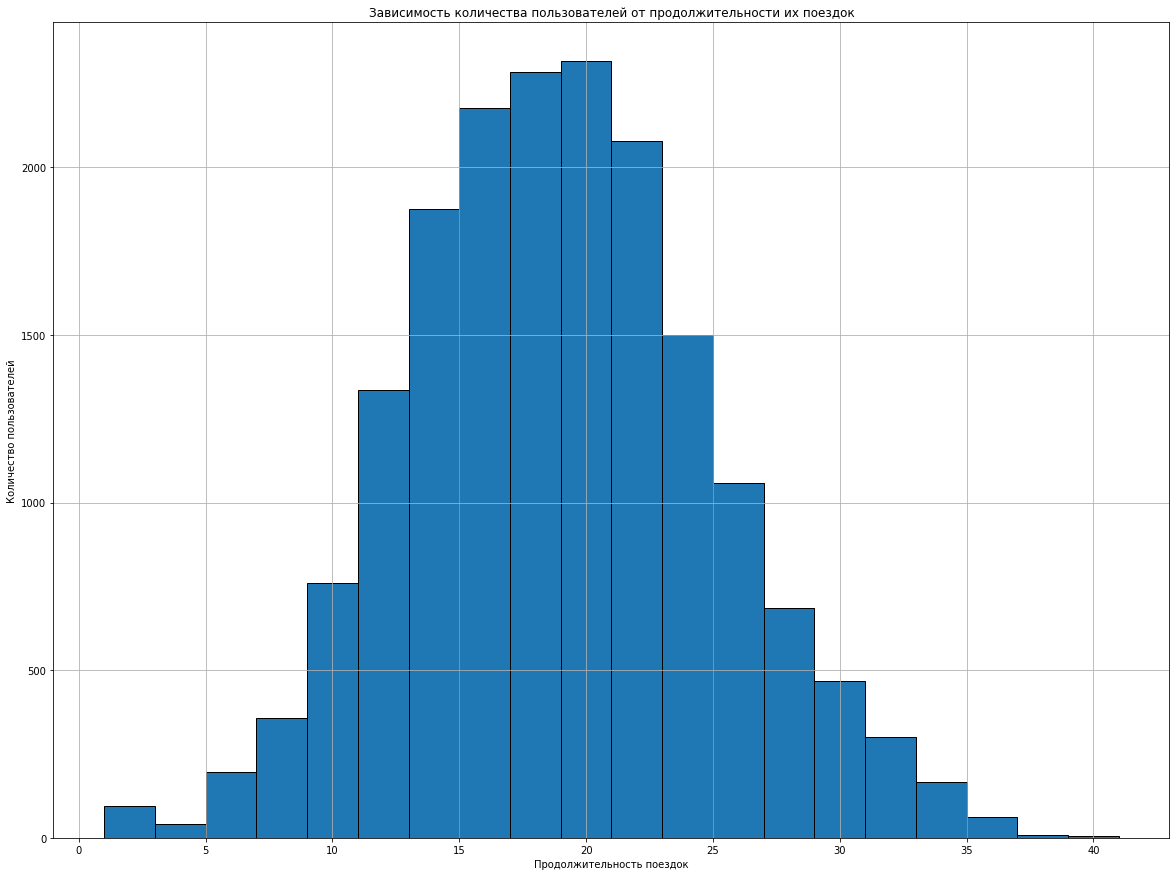

count    17775.000000
mean        18.460985
std          6.000697
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [324]:
#Гистограмма по продолжительности поездок:
rides_data['duration'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0))
plt.title('Зависимость количества пользователей от продолжительности их поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность поездок')
plt.show()

rides_data['duration'].describe()

Видим нормальное распределение данных. Пик по времени поездок приходится на область 18 минут. Особо длительных поездок (35+ минут) немного, куда больше особо коротких (менее 5 минут).

#### Вывод:
Проведён исследовательский анализ данных. Для описания 5 интересующих нас зависимостей оказалось достаточно построения гистограмм. Выделим общие положения по каждому пунтку:
  - В Москве оказалось меньше всего пользователей сервисом GoFast; выдвигаем предположение, что в Москве у сервиса больше всего конкурентов, либо же люди чаще пользуются общественным и личным транспортом. Больше всего пользователей из южной части страны (Пятигорск, Краснодар, Ростов-на-Дону). Так же отмечается Екатеринбург, там люди охотно пользуются современными сервисами;
  - Пользователей с подпиской "Ultra" оказалось ровно 700 человек, с базовой около 830. Достаточно маленькая разница, говорит о том, что люди не против приобрести подписку, видимо, часто пользуются сервисом;
  - Возраст пользователей из выборки имеет средне значение около 25 лет. Видим, что больше всего клиентов в сегменте молодых (21 - 27 лет), однако есть люди и старше, например, за 35;
  - Чаще всего самокат арендуется для преодоления средних расстояний (около 3 км). На расстояния больше 5 км люди предпочитают использовать другие средства перемещения. Также интересно, что самокат достаточно часто используется и для небольших дистанций (менее 1 км);
  - Пик по времени поездок приходится на область 18 минут. Особо длительных поездок (35+ минут) немного, куда больше особо коротких (менее 5 минут).

### Объединение данных

Объединим 3 изначальных датафрейма в один:

In [326]:
#Объединение в 2 этапа: сначала "users_data" и "rides_data" по столбцу "user_id", потом полученный датафрейм с "subscription_data"
#по стоблцу "subscription_type".
unity_data = users_data.merge(rides_data, on='user_id', how='inner').merge(subscriptions_data, on='subscription_type', how='inner')
unity_data.info()
print(unity_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 17774
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17775 non-null  int64         
 1   name               17775 non-null  object        
 2   age                17775 non-null  int64         
 3   city               17775 non-null  object        
 4   subscription_type  17775 non-null  object        
 5   distance           17775 non-null  int64         
 6   duration           17775 non-null  int64         
 7   date               17775 non-null  datetime64[ns]
 8   month              17775 non-null  int64         
 9   minute_price       17775 non-null  int64         
 10  start_ride_price   17775 non-null  int64         
 11  subscription_fee   17775 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 1.8+ MB
   user_id  name  age    city subscription_type  dis

Посмотрим, не потерялись ли какие-то строки в процессе объединения:

In [327]:
#Больше всего строк было в таблице rides_data, т.е. в итоговой таблице должно оказаться столько же строк, сколько было в ней:
print(rides_data['user_id'].count()/unity_data['user_id'].count())

1.0


Сколько строк было, столько стало.

Создадим 2 отдельные таблицы, разделив пользователей по виду подписки:

In [328]:
#Создаём новые датафреймы по типу подписки с помощью группировки:
unity_ultra_data = unity_data.query('subscription_type == "ultra"')
unity_free_data = unity_data.query('subscription_type == "free"')
print(unity_ultra_data.head())
print(unity_free_data.head())

   user_id  name  age    city subscription_type  distance  duration  \
0        1  Кира   22  Тюмень             ultra      4410        26   
1        1  Кира   22  Тюмень             ultra      2618        16   
2        1  Кира   22  Тюмень             ultra       755         7   
3        1  Кира   22  Тюмень             ultra      2695        19   
4        1  Кира   22  Тюмень             ultra      4029        27   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1             6                 0               199  
2 2021-04-20      4             6                 0               199  
3 2021-08-11      8             6                 0               199  
4 2021-08-28      8             6                 0               199  
      user_id   name  age  city subscription_type  distance  duration  \
6497      700  Айдар   22  Омск              free      2516        1

Посмотрим, как изменяться гистограммы по расстоянию и времени поездок в зависимости от начилия подписки. Сперва для "ultra":

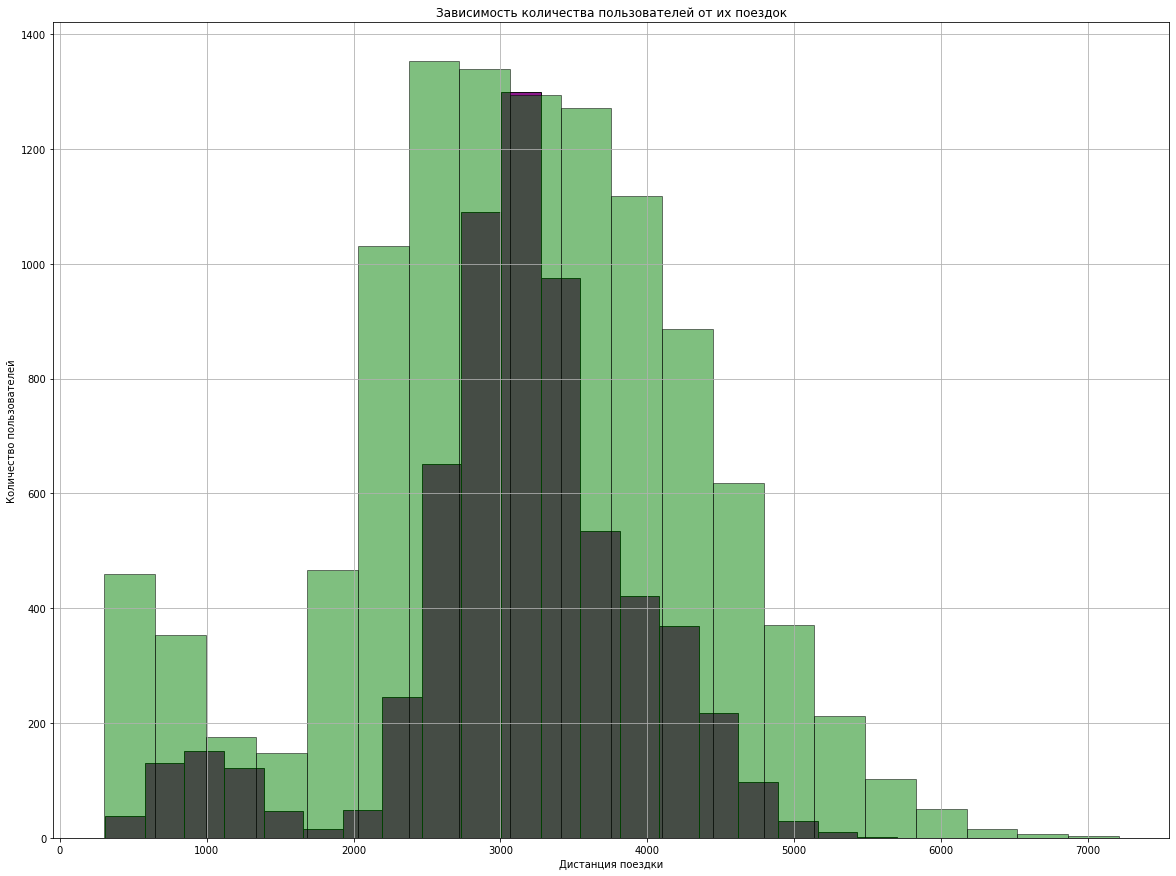

Клиенты с подпиской:
 count    6497.000000
mean     3117.265969
std       834.840813
min       308.000000
25%      2786.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64

Клиенты без подписки:
 count    11278.000000
mean      3120.027487
std       1172.197357
min        301.000000
25%       2430.000000
50%       3151.000000
75%       3932.750000
max       7212.000000
Name: distance, dtype: float64


In [354]:
#Гистограмма по расстоянию:
unity_ultra_data['distance'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0), alpha = 0.9, color='purple')
unity_free_data['distance'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0), alpha = 0.5, color='green')
plt.title('Зависимость количества пользователей от их поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Дистанция поездки')
plt.show()

print('Клиенты с подпиской:\n', unity_ultra_data['distance'].describe())
print('')
print('Клиенты без подписки:\n', unity_free_data['distance'].describe())

У клиентов без подписки поездок на дистанцию менее 1 км заметно больше, пик также смещён на 2,5 км, однако мы всё равно можем выделить основную часть поездок, которые совершаются на расстояние от 2,5 до 3,5 км. Люди без подписок также активно используют самокаты для преодоления больших расстояний (от 5 до 7 км), причём заметно больше подписчиков. Но почему тогда они не покупают подписку? Не так часто катаются? Либо же на рекламе "ultra" решили сэкономить, и пользователи не знают о её существовании?

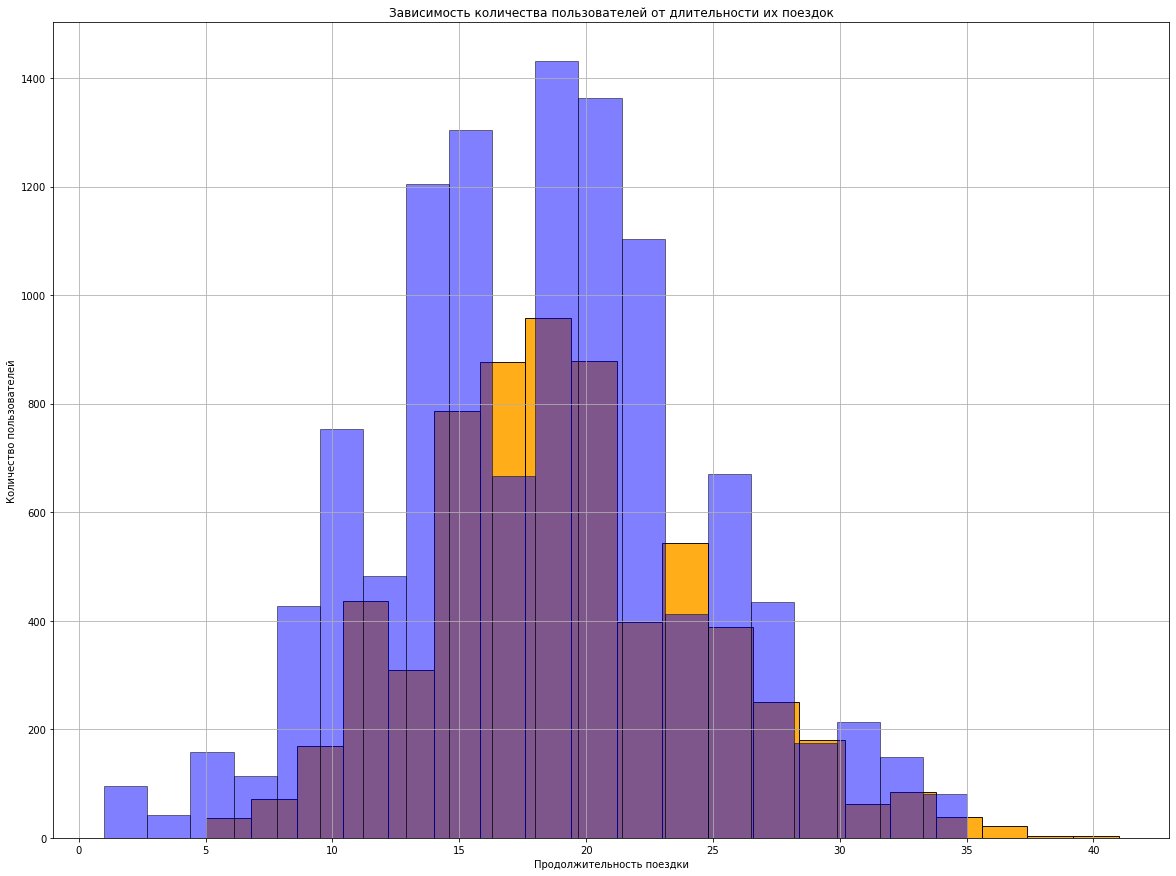

Клиенты с подпиской:
 count    6497.000000
mean       19.042635
std         5.573584
min         5.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

Клиенты без подписки:
 count    11278.000000
mean        18.125909
std          6.209028
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64


In [353]:
#Гистограмма по длительности поездок:
unity_ultra_data['duration'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0), alpha = 0.9, color='orange')
unity_free_data['duration'].hist(bins=20, figsize=(20,15), edgecolor=(0, 0, 0), alpha = 0.5, color='blue')
plt.title('Зависимость количества пользователей от длительности их поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность поездки')
plt.show()

print('Клиенты с подпиской:\n', unity_ultra_data['duration'].describe())
print('')
print('Клиенты без подписки:\n', unity_free_data['duration'].describe())

А вот гистограмма по длительности поездок практически не изменилась по сравнению с общей. Видимо, это ситуативный показатель, который зависит больше от города и его районов.

У клиентов без подписки наблюдается большее количество коротких поездкок (меньше 5 минут); график обрывается на 35 минутах, значит, действительно долгие поездки совершаются только обладателями подписки. Однако в целом поездок на 20+ минут больше, чем у подписчиков "ultra".

#### Вывод:
Исходные датафреймы были объединены в один общий, после чего тот был разбит на 2: произошло разделение клиентов с подпиской "ultra" и без. После этого произведены повторные исследования длительности поездок и их расстояний в зависимости от типа подписки. Результаты следующие:

  1) Клиенты с подпиской в основном совершают поездки на средние дистанции около 3 км, на более коротких (около 2 км) виден явный спад;
  
  2) Продолжительность поездок клиентов с подпиской не отличается от общей продолжительности, такое же нормальное распределение, середина приходится на 25 минут;
  
  3) У пользователей без подписки поездок на дистанцию менее 1 км заметно больше, пик также смещён на 2,5 км, однако мы всё равно можем выделить основную часть поездок, которые совершаются на расстояние от 2,5 до 3,5 км. Люди без подписок также активно используют самокаты для преодоления больших расстояний (от 5 до 7 км). Получается, что у отсутствия у них подписки есть конкретные причины, например, редкое использования самокатов или недостаточная реклама самой подписки;
  
  4) У пользователей без подписок больше коротких поездок (меньше 5 минут), очень долгие поездки (более 35 минут) они не совершают. Однако в целом поездок на 20+ минут больше, чем у подписчиков "ultra".

### Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма "unity_data". Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [205]:
#Создадим новый датафрейм с помощью сводных таблиц:
agg_data = unity_data.pivot_table(index=['user_id', 'month'], 
            values=['distance', 'duration', 'name', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],
            aggfunc={'distance': 'sum', 
                     'duration': 'sum', 
                     'name': 'count', 
                     'subscription_type': 'min',
                     'minute_price': 'min',
                     'start_ride_price': 'min',
                     'subscription_fee': 'min'})
agg_data.columns = ['total_distance', 
                    'total_duration', 
                    'minute_price',  
                    'trip_count', 
                    'start_ride_price',
                    'subscription_fee',
                    'subscription_type']
agg_data.info()
print(agg_data.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11241 entries, (1, 1) to (1534, 12)
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   total_distance     11241 non-null  int64 
 1   total_duration     11241 non-null  int64 
 2   minute_price       11241 non-null  int64 
 3   trip_count         11241 non-null  int64 
 4   start_ride_price   11241 non-null  int64 
 5   subscription_fee   11241 non-null  int64 
 6   subscription_type  11241 non-null  object
dtypes: int64(6), object(1)
memory usage: 659.9+ KB
               total_distance  total_duration  minute_price  trip_count  \
user_id month                                                             
1       1                7028              42             6           2   
        4                 755               7             6           1   
        8                6724              46             6           2   
        10               5811   

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [206]:
#Добавим новый столбец:
agg_data['rev_per_month'] = (agg_data['minute_price'] * agg_data['total_duration']
                            + agg_data['start_ride_price'] * agg_data['trip_count']
                            + agg_data['subscription_fee'])
print(agg_data.head())

               total_distance  total_duration  minute_price  trip_count  \
user_id month                                                             
1       1                7028              42             6           2   
        4                 755               7             6           1   
        8                6724              46             6           2   
        10               5811              32             6           2   
        11               7005              56             6           3   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               19

#### Вывод:
Был создан новый датафрейм с сортировкой пользователей по их id с помощью сводных таблиц. \
Также рассчитана и добавлена информация о месячной выручке с каждого пользователя.

### Проверка гипотез

Для успешного проведения акций необходимо исследовать 4 гипотезы. Будем делать это поочерёдно с помощью ttest. Уровень значимости везде возьмём 5%.

#### Тратят ли пользователи с подпиской больше времени на поездки? 

Выдвигаем 2 гипотезы: 
 1) H0 - время поездок у пользователей с подпиской и без одинаковое;\
 2) H1 - пользователи с подпиской тратят больше времени на поездки.

In [267]:
#Сравниваем 2 разные таблицы, поэтому используем "_ind" с неравным количеством столбцов:
results = st.ttest_ind(unity_ultra_data['duration'], unity_free_data['duration'], equal_var=False, alternative='greater')
print(results.pvalue)
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.5975963682172755e-24
Отвергаем нулевую гипотезу


##### Промежуточный вывод:
Нулевая гипотеза отвергнута, получается, подписчики "ultra" могут тратить больше времени на поездки. Математически подтвердили выводы по графикам из основной части исследования.

#### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Выдвигаем 2 гипотезы: 
 1) H0 - среднее расстояние у пользователей с подпиской равно 3130 метров;\
 2) H1 - среднее расстояние у пользователей с подпиской больше 3130 метров.

In [208]:
#Исследуем 1 таблицу, поэтому используем "_1samp":
results = st.ttest_1samp(unity_ultra_data['distance'], 3130, alternative='greater')
print(results.pvalue)
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.8905303035425329
Не получилось отвергнуть нулевую гипотезу


##### Промежуточный вывод:
Нельзя утверждать, что среднее расстояние не равно 3130 метров. Графики из основной части исследования подтверждают этот вывод.

#### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Выдвигаем 2 гипотезы: 
 1) H0 - помесячная выручка с пользователей с подпиской равна выручке с пользователей без подписки;\
 2) H1 - помесячная выручка с пользователей с подпиской больше выручки с пользователей без подписки.

In [209]:
#Разделим агрегированную таблицу по типам подписки:
agg_data_ultra = agg_data.query('subscription_type == "ultra"')
agg_data_free = agg_data.query('subscription_type == "free"')

#Проведём t-тест 2 датафреймов:
results = st.ttest_ind(agg_data_ultra['rev_per_month'], agg_data_free['rev_per_month'], equal_var=False, alternative='greater')
print(results.pvalue)
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

3.7283831516350566e-42
Отвергаем нулевую гипотезу


##### Промежуточный вывод:
Нулевая гипотеза однозначно отвергнута, значит, выгода от подписки для сервиса есть.

#### После обновления сервера количество обращений в техподдержку снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

Если учитывать, что информация в таблице есть по всем пользователям "до" и по всем "после", выборки получаются зависимыми, исследуется одна и та же таблица. Для таких случаев применяется ttest_rel(before, after).

#### Вывод:
В ходе исследования были обработаны 3 гипотезы. Результаты:
  - гипотезу о том, что среднее время поездок клиентов с подпиской и без одинаковое, отвергли;
  - гипотезу о том, что среднее расстояние поездок пользователей с подпиской равно 3130 метров, не получилось отвергнуть;
  - гипотезу о том, что средняя помесячная выручка с пользователей с подпиской равна выручке с пользователей без подписки, отвергаем.
  
В первых двух случаях получили математическое подтверждение графиков из основной части исследования. А вот прибыль с подписчиков может быть больше, поэтому есть выгода развивать эту систему.

### Распределения

#### Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. 
То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Имеем дело с биномиальным распределением (есть шанс на успех и количество попыток), которое для лучшего результата необходимо аппроксимировать нормальным распределением. Так как для точного расчёта нужны точные значения количества попыток и вероятности успеха, придётся писать функцию, чтобы потом методом подбора узнать необходимое количество промокодов.

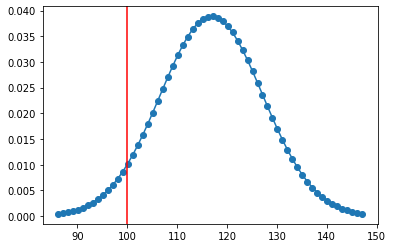

100.02841955223582

In [262]:
#Напишем функцию для построения распределения:
def bin_to_norm_for_value(n, p, x):
    # Параметры биноминального распределения:
    # n - количество экспериментов
    # p - вероятность успеха    
    # x - вероятность расчитываемого значения
    mu = n * p
    sigma = (n * p * (1 - p))**(1/2)
    
    distr = st.norm(mu, sigma)
    
    #Значение для заданной вероятности
    result = distr.ppf(x)
    
    # Построение графика
    a_range = np.arange((mu - 3 * sigma), (mu + 3 * sigma), 1)
    
    plt.plot(a_range, st.norm.pdf(a_range, mu, sigma), 'o-')
    plt.axvline(x=result, color='red')
    plt.show()
    
    return result

#Методом подбора найдём минимальное значение количества купонов:
bin_to_norm_for_value(1169, 0.1, 0.05)

##### Промежуточный вывод:
С помощью аппроксимации биномиального распределения нормальным обнаружили, что при таких исходных данных необходимо разослать 1169 купонов.

#### Построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Воспользуемся модернизированной функцией из 8.1 и методом подбора определим искомую вероятность.

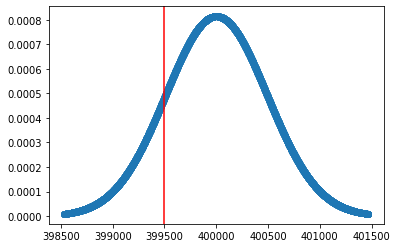

0.15371708296369768

In [263]:
#Функция bin_to_norm_for_percent:
def bin_to_norm_for_percent(n, p, x):
    # Параметры биноминального распределения:
    # n - количество экспериментов
    # p - вероятность успеха    
    # x - пороговое значение
    mu = n * p
    sigma = (n * p * (1 - p))**(1/2)
    
    distr = st.norm(mu, sigma)
    
    #Вероятность для заданной величины
    result = distr.cdf(x)
    
    # Построение графика
    a_range = np.arange((mu - 3 * sigma), (mu + 3 * sigma), 1)
    
    plt.plot(a_range, st.norm.pdf(a_range, mu, sigma), 'o-')
    plt.axvline(x=x, color='red')
    plt.show()
    
    return result

#Методом подбора найдём минимальное значение количества купонов:
bin_to_norm_for_percent(1000000, 0.4, 399500)

##### Промежуточный вывод:
Итак, если разослать 1 млн. уведомлений при вероятности открытия в 40% 399,5 тыс. пользователей откроют его с вероятностью 15,4%.

#### Вывод:
В ходе решения маркетинговых задач было написано две функции, оценивающие биномиальное распределение с помощью нормального. В первом случае можно найти величину искомого параметра, во втором - вероятность события.

### Общий вывод:
На анализ данных были представлены 3 таблицы по сервису аренды самокатов "GoFast". Первая таблица "users_go" содержала информацию о пользователях, вторая таблица "rides_go" - об их поездках, третья таблица "subscription_go" - о тарифах. 

#### Предобработка данных:
Качество данных оказалось весьма хорошим, однако предобработка всё равно была проведена.\
В ходе предобработки данных была проделана следующая работа:

 - были выявлены и удалены явные дубликаты в users_data;
 - была произведена проверка на неявные дубликаты;
 - обнаружены и удалены строки с нефизичными значениями (большие расстояния за 30 секунд, несколько метров за 10+ минут);
 - произведено округление значений в столбцах "distance" и "duration" из rides_data;
 - изменены типы данных в столбцах: "date" датафрейма rides_data, "distance" и "duration" из rides_data;
 - добавлен столбец с номером месяца.

#### Исследовательский анализ данных:
Проведён исследовательский анализ данных. Для описания 5 интересующих нас зависимостей оказалось достаточно построения гистограмм. Выделим общие положения по каждому пунтку:

 - В Москве оказалось меньше всего пользователей сервисом GoFast; выдвигаем предположение, что в Москве у сервиса больше всего конкурентов, либо же люди чаще пользуются общественным и личным транспортом. Больше всего пользователей из южной части страны (Пятигорск, Краснодар, Ростов-на-Дону). Так же отмечается Екатеринбург, там люди охотно пользуются современными сервисами;
 - Пользователей с подпиской "Ultra" оказалось ровно 700 человек, с базовой около 830. Достаточно маленькая разница, говорит о том, что люди не против приобрести подписку, видимо, часто пользуются сервисом;
 - Возраст пользователей из выборки имеет средне значение около 25 лет. Видим, что больше всего клиентов в сегменте молодых (21 - 27 лет), однако есть люди и старше, например, за 35;
 - Чаще всего самокат арендуется для преодоления средних расстояний (около 3 км). На расстояния больше 5 км люди предпочитают использовать другие средства перемещения. Также интересно, что самокат достаточно часто используется и для небольших дистанций (менее 1 км);
 - Пик по времени поездок приходится на область 18 минут. Особо длительных поездок (35+ минут) немного, куда больше особо коротких (менее 5 минут).

#### Дополнительный анализ данных:
Исходные датафреймы были объединены в один общий, после чего тот был разбит на 2: произошло разделение клиентов с подпиской "ultra" и без. После этого произведены повторные исследования длительности поездок и их расстояний в зависимости от типа подписки. Результаты следующие:

1) Клиенты с подпиской в основном совершают поездки на средние дистанции около 3 км, на более коротких (около 2 км) виден явный спад;

2) Продолжительность поездок клиентов с подпиской не отличается от общей продолжительности, такое же нормальное распределение, середина приходится на 25 минут;

3) У пользователей без подписки поездок на дистанцию менее 1 км заметно больше, пик также смещён на 2,5 км, однако мы всё равно можем выделить основную часть поездок, которые совершаются на расстояние от 2,5 до 3,5 км. Люди без подписок также активно используют самокаты для преодоления больших расстояний (от 5 до 7 км). Получается, что у отсутствия у них подписки есть конкретные причины, например, редкое использования самокатов или недостаточная реклама самой подписки;

4) У пользователей без подписок больше коротких поездок (меньше 5 минут), очень долгие поездки (более 35 минут) они не совершают. Однако в целом поездок на 20+ минут больше, чем у подписчиков "ultra".

#### Подсчёт выручки:
Был создан новый датафрейм с сортировкой пользователей по их id с помощью сводных таблиц.
Также рассчитана и добавлена информация о месячной выручке с каждого пользователя.
 
#### Проверка гипотез:
В ходе исследования были обработаны 3 гипотезы. Результаты:

 - гипотезу о том, что среднее время поездок клиентов с подпиской и без одинаковое, отвергли, с подпиской катаются дольше;
 - гипотезу о том, что среднее расстояние поездок пользователей с подпиской равно 3130 метров, не получилось отвергнуть;
 - гипотезу о том, что средняя помесячная выручка с пользователей с подпиской равна выручке с пользователей без подписки, отвергаем.
В первых двух случаях получили математическое подтверждение графиков из основной части исследования. А вот прибыль с подписчиков может быть больше, поэтому есть выгода развивать эту систему.

#### Решение маркетинговых задач:
В ходе решения маркетинговых задач было написано две функции, оценивающие биномиальное распределение с помощью нормального. В первом случае можно найти величину искомого параметра, во втором - вероятность события. Результаты:
 - для того, чтобы 100 пользователей купили подписку после пробного периода, необходимо разослать 1170 купонов;
 - вероятность того, что 400 тысяч пользователей кликнут на уведомление при рассылке в 1 млн. копий, равна 15,4%.

#### Итог:
В ходе анализа данных все поставленные задачи были выполнены: построены информативные графики зависимости величин друг от друга и необходимые гистограммы, получены конкретные результаты по каждому пункту. Обработанных данных оказалось достаточно для анализа и решения задач, дополнительных исследований не требуется.